# Deep Learning Project(피부 질환 분류)

## INDEX
- EDA
- Train, Validation, Test split / Function
- Modeling
  - efficientnetB5 , vgg16 , resnet150v2 , resnet50v2 , densenet201 , xception
- Modeling 
  - efficientnetB5(정상 데이터 추가, 판별 불가한 사진 제거, 이미지를 자르지 않는 증강만 사용) + fine tunning

In [1]:
!pip install split-folders

import tensorflow as tf
import splitfolders
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
import numpy as np
import pandas as pd
import random
import shutil
import time
import cv2 as cv2
import itertools
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mping
import os
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---

## EDA

In [ ]:
# 1. Eczema 1677
# 2. Melanoma 15.75k
# 3. Atopic Dermatitis - 1.25k
# 4. Basal Cell Carcinoma (BCC) 3323
# 5. Melanocytic Nevi (NV) - 7970
# 6. Benign Keratosis-like Lesions (BKL) 2624
# 7. Psoriasis pictures Lichen Planus and related diseases - 2k
# 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
# 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
# 10. Warts Molluscum and other Viral Infections - 2103

class_ = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
class_count = [1677, 1575, 1250, 3323, 7970, 2624, 2000, 1800, 1700, 2103]

df = pd.DataFrame({'class': class_, 'class_count': class_count})
df = df.sort_values(by='class_count', ascending=False)
df

,class,class_count
4,5,7970
3,4,3323
5,6,2624
9,10,2103
6,7,2000
7,8,1800
8,9,1700
0,1,1677
1,2,1575
2,3,1250


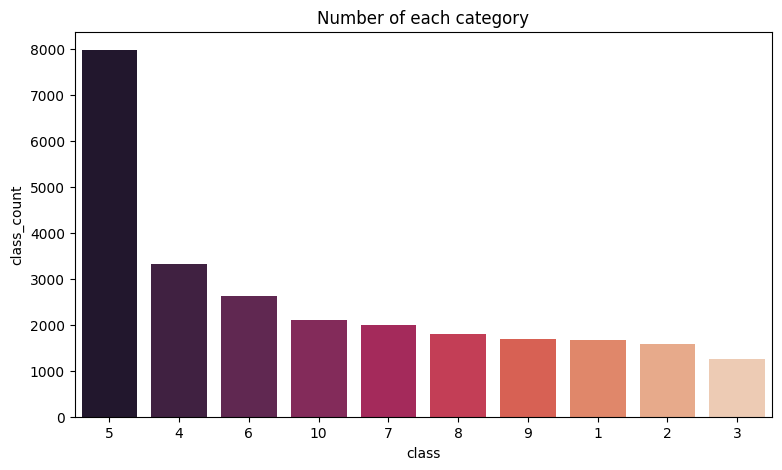

In [ ]:
# 클래스별 개수 확인

plt.figure(figsize=(9,5))
sns.barplot(x=df['class'], y=df['class_count'], palette='rocket')
plt.title('Number of each category')
plt.show();

In [ ]:
# plot image

def plot_random_image(target_dir,target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder),1)
    img = mping.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    return img

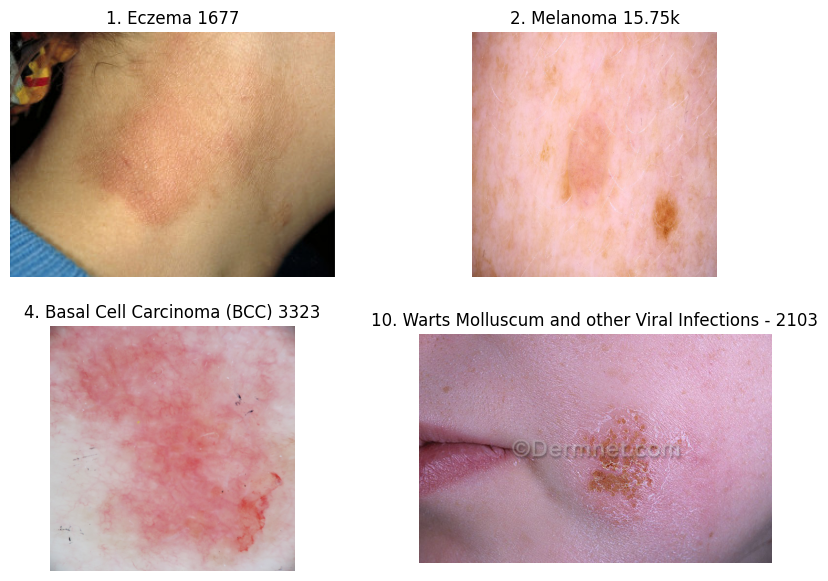

In [ ]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2,2,1)
img_1 = plot_random_image(target_dir = "/content/drive/MyDrive/colabnotebook/IMG_CLASSES/",target_class = "1. Eczema 1677")
fig.add_subplot(2,2,2)
img_2 = plot_random_image(target_dir = "/content/drive/MyDrive/colabnotebook/IMG_CLASSES/",target_class = "2. Melanoma 15.75k")
fig.add_subplot(2,2,3)
img_3 = plot_random_image(target_dir = "/content/drive/MyDrive/colabnotebook/IMG_CLASSES/",target_class = "4. Basal Cell Carcinoma (BCC) 3323")
fig.add_subplot(2,2,4)
img_4 = plot_random_image(target_dir = "/content/drive/MyDrive/colabnotebook/IMG_CLASSES/",target_class = "10. Warts Molluscum and other Viral Infections - 2103")

---

## Train, Validation, Test split / Function

In [ ]:
# %cd /content/drive/MyDrive/colabnotebook

# !unzip -qq "/content/drive/MyDrive/colabnotebook/archive (1).zip"

In [ ]:
# train / validation / test

def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)       
    # split df into train_df and test_df 
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    return train_df, test_df, valid_df

In [ ]:
sdir=r'/content/drive/MyDrive/colabnotebook/IMG_CLASSES'
train_df, test_df, valid_df= preprocess(sdir, .8,.1)

In [ ]:
# 증강 X
# 변수명 : train_gen_n, test_gen_n, valid_gen_n

channels=3
batch_size=32
img_shape=(224, 224, channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen_n=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                    shuffle=True, batch_size=batch_size)
test_gen_n=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                    shuffle=False, batch_size=test_batch_size)

valid_gen_n=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                    shuffle=True, batch_size=batch_size)

classes=list(train_gen_n.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen_n.labels)/batch_size))

In [ ]:
# 증강 O
# 변수명 : train_gen_o, test_gen_o, valid_gen_o

channels=3
batch_size=128
img_shape=(224, 224, channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen_o=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size, rotation_range=30, width_shift_range=0.1,
                                    height_shift_range=0.1, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")
test_gen_o=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen_o=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen_o.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen_o.labels)/batch_size))

In [ ]:
# 모델

def get_model(model): 
    kwargs = {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':None,
                'pooling':'avg'
              }
    
    pretrained_model = model(**kwargs)

    x=pretrained_model.output
    x=Dense(1064, name='fully')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(rate=.35, seed=123)(x)
    output=Dense(10, activation='softmax',name='softmax')(x)
    model=Model(pretrained_model.input,output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

    return model

In [ ]:
# accuracy, loss 그래프

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  fig = plt.figure(figsize=(16, 5))
  fig.add_subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  fig.add_subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
# print info

def print_info( test_gen, preds, print_code, save_dir):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key            

    classes=list(new_dict.values())      
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  
        if pred_index != true_index: 
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                             
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)   
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
# efficientnet split

# !pip install split-folders

os.makedirs('/content/drive/MyDrive/colabnotebook/output')
os.makedirs('/content/drive/MyDrive/colabnotebook/output/train')
os.makedirs('/content/drive/MyDrive/colabnotebook/output/val')
os.makedirs('/content/drive/MyDrive/colabnotebook/output/test')

loc = "/content/drive/MyDrive/colabnotebook/IMG_CLASSES"

splitfolders.ratio(loc,output = '/content/drive/MyDrive/colabnotebook/output',seed = 42,ratio = (0.80,.1,.1))

train_dir = "/content/drive/MyDrive/colabnotebook/output/train"
test_dir =  "/content/drive/MyDrive/colabnotebook/output/test"
val_dir = "/content/drive/MyDrive/colabnotebook/output/val"

train_data = image_dataset_from_directory(train_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = True,seed = 42)
test_data = image_dataset_from_directory(test_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = False,seed = 42)
val_data = image_dataset_from_directory(val_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = False,seed = 42)

Copying files: 27153 files [12:49, 35.31 files/s] 


Found 21719 files belonging to 10 classes.
Found 2723 files belonging to 10 classes.
Found 2711 files belonging to 10 classes.


In [ ]:
# class 개수와 종류 확인
class_names = train_data.class_names
print(len(class_names))
print(class_names)

In [ ]:
train_data = train_data.prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# efficientnet 데이터 증강

data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomCrop(height=200, width=200), # 이미지를 무작위로 자르기
    ], name="data_augmentation_layer")

In [ ]:
# efficientnet 증강 X

def no_augmented_model(model): 

  base_model = model(include_top = False)
  base_model.trainable = False

  inputs = layers.Input(shape = (224,224,3),name = "input_layer")
  x = inputs
  x = base_model(x)
  x = layers.GlobalAvgPool2D(name = "pooling_layer")(x)
  x = layers.Dense(64,activation = "relu",kernel_initializer = tf.keras.initializers.he_normal())(x)
  x = layers.Dropout(rate=.45)(x)
  x = layers.Dense(10)(x)
  outputs = layers.Activation("softmax",dtype = tf.float32)(x)
  model = tf.keras.Model(inputs,outputs)

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),
             metrics = ["accuracy"])
  
  return model

In [ ]:
# efficientnet 증강 O

def augmented_model(model): 

  base_model = model(include_top = False)
  base_model.trainable = False

  inputs = layers.Input(shape = (224,224,3),name = "input_layer")
  x = data_aug(inputs)
  x = base_model(x)
  x = layers.GlobalAvgPool2D(name = "pooling_layer")(x)
  x = layers.Dense(64,activation = "relu",kernel_initializer = tf.keras.initializers.he_normal())(x)
  x = layers.Dropout(rate=.45)(x)
  x = layers.Dense(10)(x)
  outputs = layers.Activation("softmax",dtype = tf.float32)(x)
  model = tf.keras.Model(inputs,outputs)

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),
             metrics = ["accuracy"])
  
  return model

In [ ]:
# efficientnet confusion matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(5,5), text_size=10, norm=False, savefig=False): 
 
  # confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels, 
         yticklabels=labels)
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # 클래스가 11개인 경우 xticks와 yticks에 11을 추가
  if n_classes == 11:
    plt.xticks(np.arange(n_classes+1), fontsize=text_size)
    plt.yticks(np.arange(n_classes+1), fontsize=text_size)

  # 저장
  if savefig:
    fig.savefig("confusion_matrix.png")

----

## Modeling

- efficientnetB5(augmentation X)

In [ ]:
m_e_n = no_augmented_model(tf.keras.applications.EfficientNetB5)

115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 7, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 4,min_lr = 1e-7)

history_e_n = m_e_n.fit(train_data, epochs=30, shuffle=None, validation_data=val_data, callbacks=[early_stop, reduce_lr])

Epoch 1/30
679/679 [==============================] - 66s 60ms/step - loss: 1.1298 - accuracy: 0.5743 - val_loss: 0.8643 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 2/30
679/679 [==============================] - 38s 55ms/step - loss: 0.9267 - accuracy: 0.6421 - val_loss: 0.8000 - val_accuracy: 0.6879 - lr: 0.0010
Epoch 3/30
679/679 [==============================] - 38s 56ms/step - loss: 0.8640 - accuracy: 0.6703 - val_loss: 0.7762 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 4/30
679/679 [==============================] - 38s 55ms/step - loss: 0.8230 - accuracy: 0.6839 - val_loss: 0.7495 - val_accuracy: 0.7138 - lr: 0.0010
Epoch 5/30
679/679 [==============================] - 38s 55ms/step - loss: 0.7949 - accuracy: 0.6983 - val_loss: 0.7325 - val_accuracy: 0.7211 - lr: 0.0010
Epoch 6/30
679/679 [==============================] - 38s 55ms/step - loss: 0.7615 - accuracy: 0.7081 - val_loss: 0.7275 - val_accuracy: 0.7296 - lr: 0.0010
Epoch 7/30
679/679 [==============================] - 38s 

In [ ]:
print("Validation Accuracy",m_e_n.evaluate(val_data))
print("Testing Accuracy",m_e_n.evaluate(test_data)) 

85/85 [==============================] - 4s 49ms/step - loss: 0.6650 - accuracy: 0.7669
Validation Accuracy [0.664998471736908, 0.766875684261322]
86/86 [==============================] - 4s 49ms/step - loss: 0.6350 - accuracy: 0.7672
Testing Accuracy [0.6350185871124268, 0.7671685814857483]


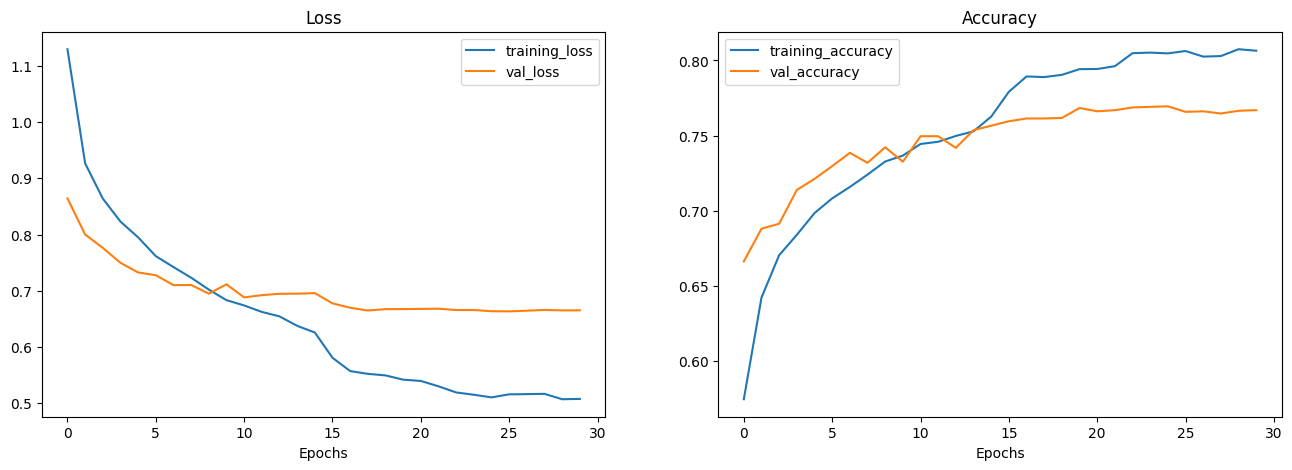

In [ ]:
plot_loss_curves(history_e_n)

In [ ]:
pred_probs = m_e_n.predict(test_data)
pred_classes = pred_probs.argmax(axis =1)
y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())

86/86 [==============================] - 4s 46ms/step


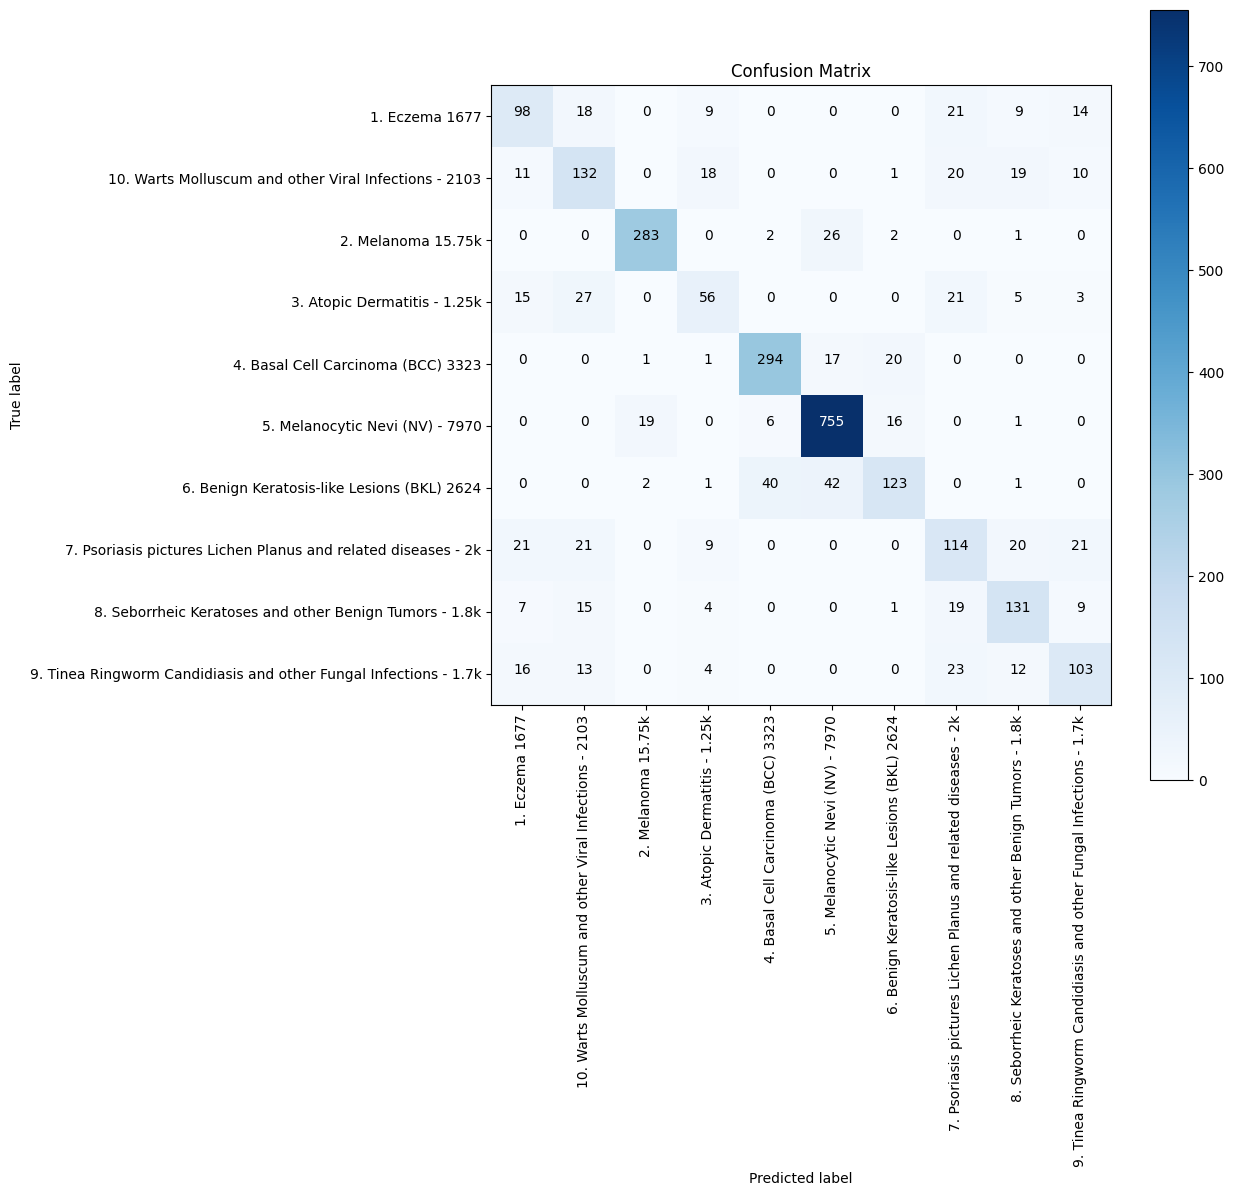

In [ ]:
# confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))

In [ ]:
# classification report

print("Classification report\n",classification_report(y_labels,pred_classes))

Classification report
               precision    recall  f1-score   support

           0       0.58      0.58      0.58       169
           1       0.58      0.63      0.60       211
           2       0.93      0.90      0.91       314
           3       0.55      0.44      0.49       127
           4       0.86      0.88      0.87       333
           5       0.90      0.95      0.92       797
           6       0.75      0.59      0.66       209
           7       0.52      0.55      0.54       206
           8       0.66      0.70      0.68       186
           9       0.64      0.60      0.62       171

    accuracy                           0.77      2723
   macro avg       0.70      0.68      0.69      2723
weighted avg       0.77      0.77      0.76      2723



- efficientnetB5(augmentation O)

In [ ]:
m_e_o = augmented_model(tf.keras.applications.EfficientNetB5)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 10, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_e_o = m_e_o.fit(train_data, epochs=60, shuffle=None, validation_data=val_data, callbacks=[early_stop, reduce_lr])

Epoch 1/60
679/679 [==============================] - 58s 59ms/step - loss: 1.2545 - accuracy: 0.5253 - val_loss: 1.0056 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 2/60
679/679 [==============================] - 37s 53ms/step - loss: 1.0829 - accuracy: 0.5883 - val_loss: 0.9320 - val_accuracy: 0.6451 - lr: 0.0010
Epoch 3/60
679/679 [==============================] - 37s 54ms/step - loss: 1.0300 - accuracy: 0.6067 - val_loss: 0.9182 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 4/60
679/679 [==============================] - 37s 53ms/step - loss: 1.0000 - accuracy: 0.6166 - val_loss: 0.8814 - val_accuracy: 0.6736 - lr: 0.0010
Epoch 5/60
679/679 [==============================] - 37s 54ms/step - loss: 0.9744 - accuracy: 0.6221 - val_loss: 0.8787 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 6/60
679/679 [==============================] - 37s 53ms/step - loss: 0.9603 - accuracy: 0.6307 - val_loss: 0.8732 - val_accuracy: 0.6717 - lr: 0.0010
Epoch 7/60
679/679 [==============================] - 37s 

In [ ]:
print("Validation Accuracy",m_e_o.evaluate(val_data))
print("Testing Accuracy",m_e_o.evaluate(test_data)) 

85/85 [==============================] - 4s 46ms/step - loss: 0.7441 - accuracy: 0.7304
Validation Accuracy [0.7440856695175171, 0.730357825756073]
86/86 [==============================] - 4s 49ms/step - loss: 0.7235 - accuracy: 0.7209
Testing Accuracy [0.7235457897186279, 0.7208960652351379]


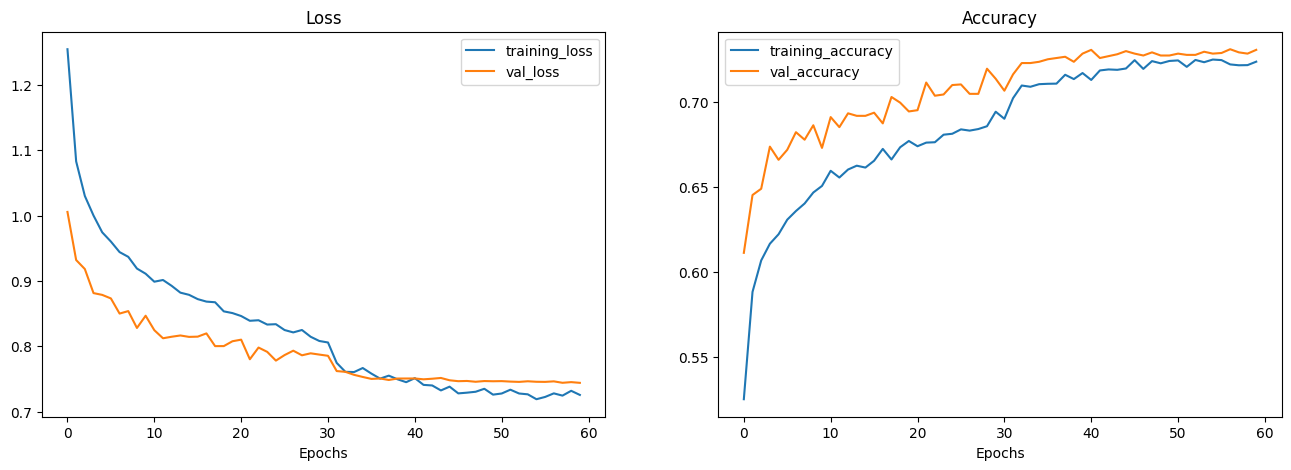

In [ ]:
plot_loss_curves(history_e_o)

In [ ]:
pred_probs = m_e_o.predict(test_data)
pred_classes = pred_probs.argmax(axis =1)
y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())

86/86 [==============================] - 7s 44ms/step


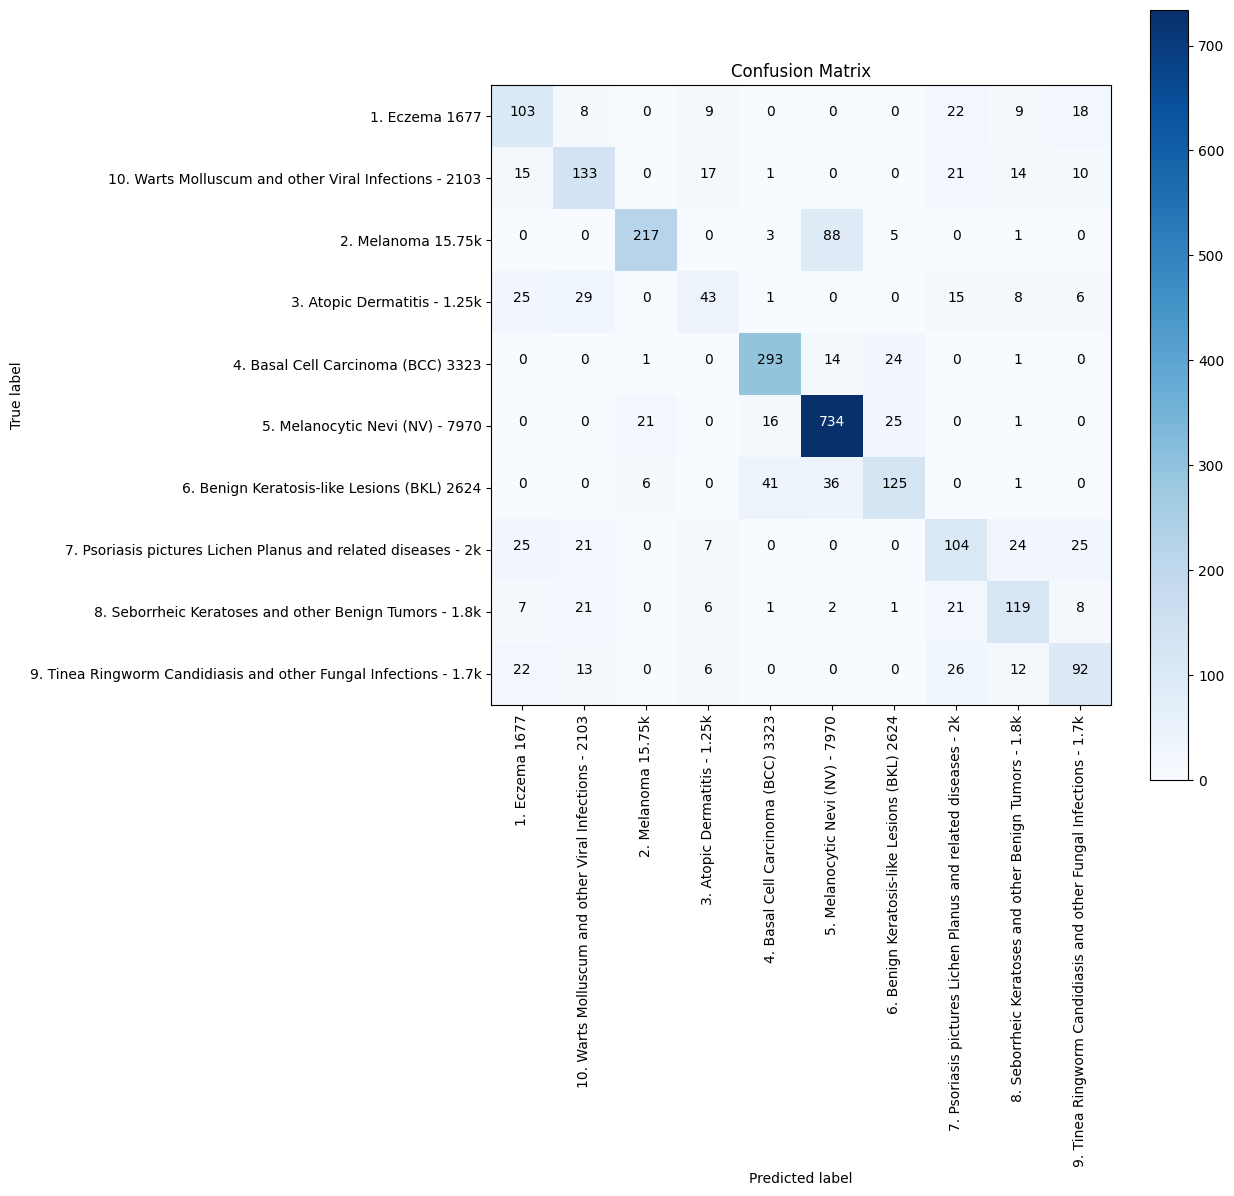

In [ ]:
# confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))

In [ ]:
# classification report

print("Classification report\n",classification_report(y_labels,pred_classes))

Classification report
               precision    recall  f1-score   support

           0       0.52      0.61      0.56       169
           1       0.59      0.63      0.61       211
           2       0.89      0.69      0.78       314
           3       0.49      0.34      0.40       127
           4       0.82      0.88      0.85       333
           5       0.84      0.92      0.88       797
           6       0.69      0.60      0.64       209
           7       0.50      0.50      0.50       206
           8       0.63      0.64      0.63       186
           9       0.58      0.54      0.56       171

    accuracy                           0.72      2723
   macro avg       0.65      0.64      0.64      2723
weighted avg       0.72      0.72      0.72      2723



- vgg16(augmentation X)

In [ ]:
m_v_n = get_model(tf.keras.applications.VGG16)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_v_n = m_v_n.fit(train_gen_n, epochs=40, shuffle=None, validation_data=valid_gen_n, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_v_n.evaluate(valid_gen_n))
print("Testing Accuracy",m_v_n.evaluate(test_gen_n)) 

In [ ]:
plot_loss_curves(history_v_n)

In [ ]:
print_code=0
preds=m_v_n.predict(test_gen_n, steps=test_steps, verbose=1) 
print_info( test_gen_n, preds, print_code, '/content/drive/MyDrive/colabnotebook')  

- vgg16(augmentation O)

In [ ]:
m_v_o = get_model(tf.keras.applications.VGG16)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_v_o = m_v_o.fit(train_gen_o, epochs=40, shuffle=None, validation_data=valid_gen_o, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_v_o.evaluate(valid_gen_o))
print("Testing Accuracy",m_v_o.evaluate(test_gen_o))

In [ ]:
plot_loss_curves(history_v_o)

In [ ]:
print_code=0
preds=m_v_o.predict(test_gen_o, steps=test_steps, verbose=1) 
print_info( test_gen_o, preds, print_code, '/content/drive/MyDrive/colabnotebook')  

- resnet152v2(augmentation X)

In [ ]:
m_r152_n = get_model(tf.keras.applications.ResNet152V2)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_r152_n = m_r152_n.fit(train_gen_n, epochs=40, shuffle=None, validation_data=valid_gen_n, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_r152_n.evaluate(valid_gen_n))
print("Testing Accuracy",m_r152_n.evaluate(test_gen_n)) 

In [ ]:
plot_loss_curves(history_r152_n)

In [ ]:
print_code=0
preds=m_r152_n.predict(test_gen_n, steps=test_steps, verbose=1) 
print_info( test_gen_n, preds, print_code, '/content/drive/MyDrive/colabnotebook') 

- resnet152v2(augmentation O)

In [ ]:
m_r152_o = get_model(tf.keras.applications.ResNet152V2)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_r152_o = m_r152_o.fit(train_gen_o, epochs=40, shuffle=None, validation_data=valid_gen_o, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_r152_o.evaluate(valid_gen_o))
print("Testing Accuracy",m_r152_o.evaluate(test_gen_o))

In [ ]:
plot_loss_curves(history_r152_o)

In [ ]:
print_code=0
preds=m_r152_o.predict(test_gen_o, steps=test_steps, verbose=1) 
print_info( test_gen_o, preds, print_code, '/content/drive/MyDrive/colabnotebook') 

- resnet50v2(augmentation X)

In [ ]:
m_r50_n = get_model(tf.keras.applications.ResNet50V2)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_r50_n = m_r50_n.fit(train_gen_n, epochs=40, shuffle=None, validation_data=valid_gen_n, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_r50_n.evaluate(valid_gen_n))
print("Testing Accuracy",m_r50_n.evaluate(test_gen_n)) 

In [ ]:
plot_loss_curves(history_r50_n)

In [ ]:
print_code=0
preds=m_r50_n.predict(test_gen_n, steps=test_steps, verbose=1) 
print_info( test_gen_n, preds, print_code, '/content/drive/MyDrive/colabnotebook') 

- resnet50v2(augmentation O)

In [ ]:
m_r50_o = get_model(tf.keras.applications.ResNet50V2)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_r50_o = m_r50_o.fit(train_gen_o, epochs=40, shuffle=None, validation_data=valid_gen_o, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_r50_o.evaluate(valid_gen_o))
print("Testing Accuracy",m_r50_o.evaluate(test_gen_o)) 

In [ ]:
plot_loss_curves(history_r50_o)

In [ ]:
print_code=0
preds=m_r50_o.predict(test_gen_o, steps=test_steps, verbose=1) 
print_info( test_gen_o, preds, print_code, '/content/drive/MyDrive/colabnotebook') 

- densenet201(augmentation X)

In [ ]:
m_d_n = get_model(tf.keras.applications.DenseNet201)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_d_n = m_d_n.fit(train_gen_n, epochs=40, shuffle=None, validation_data=valid_gen_n, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_d_n.evaluate(valid_gen_n))
print("Testing Accuracy",m_d_n.evaluate(test_gen_n)) 

In [ ]:
plot_loss_curves(history_d_n)

In [ ]:
print_code=0
preds=m_d_n.predict(test_gen_n, steps=test_steps, verbose=1) 
print_info( test_gen_n, preds, print_code, '/content/drive/MyDrive/colabnotebook') 

- densenet201(augmentation O)

In [ ]:
m_d_o = get_model(tf.keras.applications.DenseNet201)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_d_o = m_d_o.fit(train_gen_o, epochs=40, shuffle=None, validation_data=valid_gen_o, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_d_o.evaluate(valid_gen_o))
print("Testing Accuracy",m_d_o.evaluate(test_gen_o)) 

In [ ]:
plot_loss_curves(history_d_o)

In [ ]:
print_code=0
preds=m_d_o.predict(test_gen_o, steps=test_steps, verbose=1) 
print_info( test_gen_o, preds, print_code, '/content/drive/MyDrive/colabnotebook') 

- xception(augmentation X)

In [ ]:
m_x_n = get_model(tf.keras.applications.Xception)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_x_n = m_x_n.fit(train_gen_n, epochs=40, shuffle=None, validation_data=valid_gen_n, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_x_n.evaluate(valid_gen_n))
print("Testing Accuracy",m_x_n.evaluate(test_gen_n)) 

In [ ]:
plot_loss_curves(history_x_n)

In [ ]:
print_code=0
preds=m_x_n.predict(test_gen_n, steps=test_steps, verbose=1) 
print_info( test_gen_n, preds, print_code, '/content/drive/MyDrive/colabnotebook') 

- xception(augmentation O)

In [ ]:
m_x_o = get_model(tf.keras.applications.Xception)

In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6, min_delta = 0.0001)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 6,min_lr = 1e-7)

history_x_o = m_x_o.fit(train_gen_o, epochs=40, shuffle=None, validation_data=valid_gen_o, callbacks=[early_stop, reduce_lr])

In [ ]:
print("Validation Accuracy",m_x_o.evaluate(valid_gen_o))
print("Testing Accuracy",m_x_o.evaluate(test_gen_o)) 

In [ ]:
plot_loss_curves(history_x_o)

In [ ]:
print_code=0
preds=m_x_o.predict(test_gen_o, steps=test_steps, verbose=1) 
print_info( test_gen_o, preds, print_code, '/content/drive/MyDrive/colabnotebook') 

- 이전 과정
  - 모델들이 공통적으로 증강 후 accuracy가 감소하는 모양을 보임
  - 의료 데이터 특성상 이미지의 특정 부분에 병변이 있는데 증강을 하는 과정에서 병변이 사라졌거나 잘못된 이미지가 생성되었을 수 있다고 생각되며 증강 전, 후의 confusion matrix를 보았을때 어느정도 과적합된 모델이라는 것을 알 수 있음
  - 또한 클래스별로 f1-score의 편차가 있었으며 원본 데이터의 특정 클래스에는 피부 표면 사진이 아닌 데이터가 있음
  - 정상 데이터가 없어서 정상인 사진은 판별하지 못함

- 이후 과정
  - test accuracy가 가장 좋았던 efficientnet을 최종적으로 선택
  - 정상 피부 데이터 1000장 0번 클래스로 추가
  - 피부 표면 사진이 아닌 데이터 제거
  - 필요한 증강만 사용
  - efficientnet 모델링
  - fine tunning


In [ ]:
# IMG_CLASS_2 unzip

%cd /content/drive/MyDrive/colabnotebook

!unzip -qq "/content/drive/MyDrive/colabnotebook/IMG_CLASSES_2.zip"

/content/drive/MyDrive/colabnotebook


In [ ]:
# split

os.makedirs('/content/drive/MyDrive/colabnotebook/final')
os.makedirs('/content/drive/MyDrive/colabnotebook/final/train')
os.makedirs('/content/drive/MyDrive/colabnotebook/final/val')
os.makedirs('/content/drive/MyDrive/colabnotebook/final/test')

loc = "/content/drive/MyDrive/colabnotebook/IMG_CLASSES_2"

splitfolders.ratio(loc,output = '/content/drive/MyDrive/colabnotebook/final',seed = 42,ratio = (0.80,.1,.1))

train_dir = "/content/drive/MyDrive/colabnotebook/final/train"
test_dir =  "/content/drive/MyDrive/colabnotebook/final/test"
val_dir = "/content/drive/MyDrive/colabnotebook/final/val"

train_data_f = image_dataset_from_directory(train_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = True,seed = 42)
test_data_f = image_dataset_from_directory(test_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = False,seed = 42)
val_data_f = image_dataset_from_directory(val_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = False,seed = 42)

Copying files: 28001 files [04:35, 101.80 files/s]


Found 22398 files belonging to 11 classes.
Found 2807 files belonging to 11 classes.
Found 2796 files belonging to 11 classes.


In [ ]:
# class 개수와 종류 확인
class_names_2 = train_data_f.class_names
print(len(class_names_2))
print(class_names_2)

11
['0. Normal 1000', '1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


In [ ]:
train_data_f = train_data_f.prefetch(buffer_size = tf.data.AUTOTUNE)
test_data_f = test_data_f.prefetch(buffer_size = tf.data.AUTOTUNE)
val_data_f = val_data_f.prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
data_aug_2 = tf.keras.Sequential([
    preprocessing.RandomRotation(0.3),
    preprocessing.RandomFlip("horizontal"),
    ], name="data_augmentation_layer")

In [ ]:
# efficientnet class 11

base_model_11 = tf.keras.applications.EfficientNetB5(include_top = False)
base_model_11.trainable = False

inputs = layers.Input(shape = (224,224,3),name = "input_layer")
x = data_aug_2(inputs)
x = base_model_11(x)
x = layers.GlobalAvgPool2D(name = "pooling_layer")(x)
x = layers.Dense(64,activation = "relu",kernel_initializer = tf.keras.initializers.he_normal())(x)
x = layers.Dropout(rate=.45)(x)
x = layers.Dense(11)(x)
outputs = layers.Activation("softmax",dtype = tf.float32)(x)
m_11 = tf.keras.Model(inputs,outputs)

m_11.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),
            metrics = ["accuracy"])
  

115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
# val_loss가 더 이상 감소되지 않을 경우
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='auto', restore_best_weights=True)
# factor : learning rate얼마나 감소시킬지 정하는 인자값
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2, patience = 5,min_lr = 1e-7)

history_11 = m_11.fit(train_data_f, epochs=40, shuffle=None, validation_data=val_data_f, callbacks=[early_stop, reduce_lr])

Epoch 1/40
700/700 [==============================] - 72s 64ms/step - loss: 1.1929 - accuracy: 0.5605 - val_loss: 0.9109 - val_accuracy: 0.6609 - lr: 0.0010
Epoch 2/40
700/700 [==============================] - 41s 58ms/step - loss: 0.9885 - accuracy: 0.6256 - val_loss: 0.8758 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 3/40
700/700 [==============================] - 41s 58ms/step - loss: 0.9371 - accuracy: 0.6444 - val_loss: 0.8065 - val_accuracy: 0.6967 - lr: 0.0010
Epoch 4/40
700/700 [==============================] - 41s 59ms/step - loss: 0.9053 - accuracy: 0.6536 - val_loss: 0.7951 - val_accuracy: 0.7039 - lr: 0.0010
Epoch 5/40
700/700 [==============================] - 41s 58ms/step - loss: 0.8807 - accuracy: 0.6626 - val_loss: 0.7969 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 6/40
700/700 [==============================] - 41s 59ms/step - loss: 0.8723 - accuracy: 0.6687 - val_loss: 0.7763 - val_accuracy: 0.7089 - lr: 0.0010
Epoch 7/40
700/700 [==============================] - 41s 

In [ ]:
print("Validation Accuracy",m_11.evaluate(val_data_f))
print("Testing Accuracy",m_11.evaluate(test_data_f))

88/88 [==============================] - 4s 50ms/step - loss: 0.6733 - accuracy: 0.7536
Validation Accuracy [0.6733489632606506, 0.7535765171051025]
88/88 [==============================] - 5s 51ms/step - loss: 0.6301 - accuracy: 0.7553
Testing Accuracy [0.6301331520080566, 0.7552547454833984]


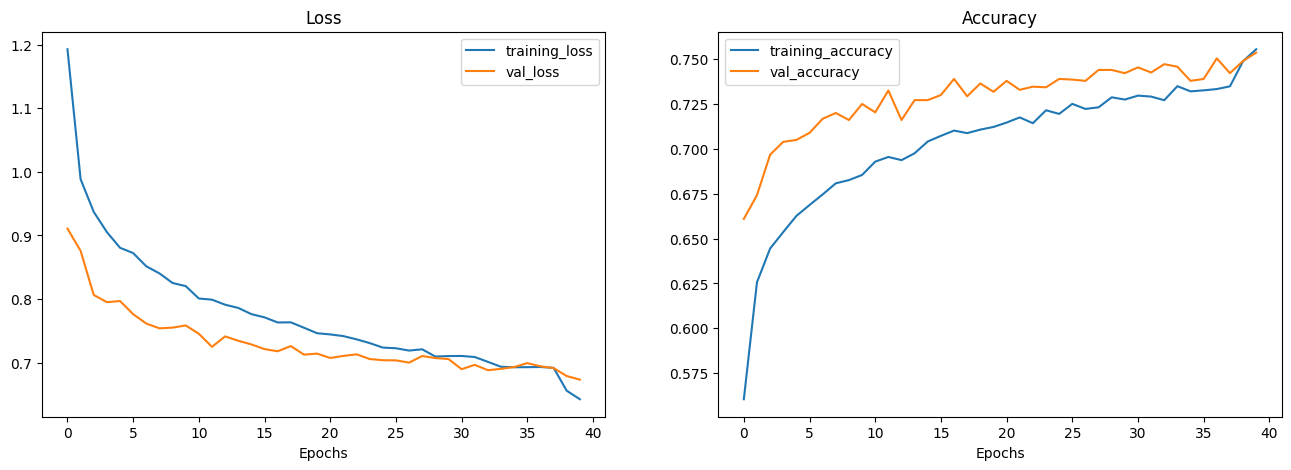

In [ ]:
plot_loss_curves(history_11)

In [ ]:
pred_probs = m_11.predict(test_data_f)
pred_classes = pred_probs.argmax(axis =1)
y_labels = []
for image,label in test_data_f.unbatch():
    y_labels.append(label.numpy().argmax())

88/88 [==============================] - 8s 50ms/step


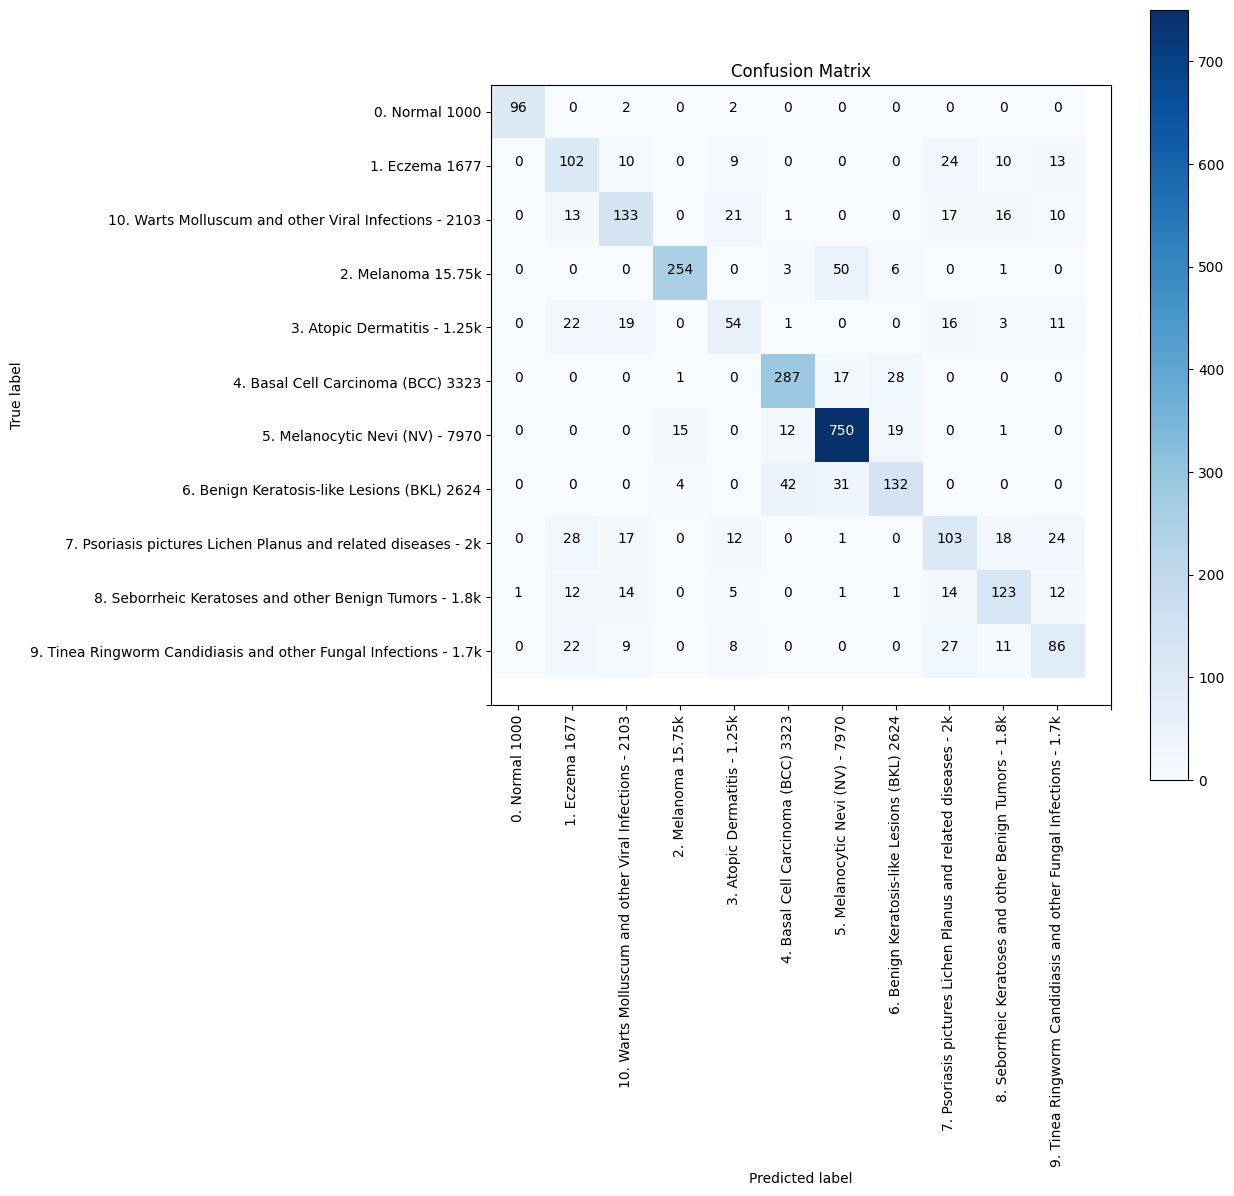

In [ ]:
# confusion matrix

make_confusion_matrix(y_labels,pred_classes,classes = class_names_2,figsize = (10,10))

In [ ]:
# classification report

print("Classification report\n",classification_report(y_labels,pred_classes))

Classification report
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       100
           1       0.51      0.61      0.56       168
           2       0.65      0.63      0.64       211
           3       0.93      0.81      0.86       314
           4       0.49      0.43      0.46       126
           5       0.83      0.86      0.85       333
           6       0.88      0.94      0.91       797
           7       0.71      0.63      0.67       209
           8       0.51      0.51      0.51       203
           9       0.67      0.67      0.67       183
          10       0.55      0.53      0.54       163

    accuracy                           0.76      2807
   macro avg       0.70      0.69      0.69      2807
weighted avg       0.76      0.76      0.75      2807



- fine tunning 
  - 모델의 성능을 향상시키기 위해, 출력층 근처에 있는 상위 30개 층을 동결해제하고, 미리 학습된 가중치 대신에 가지고 있는 데이터로 층을 학습

In [ ]:
# fine-tunning

base_model_11.trainable = True

for layer in base_model_11.layers[:-30]:
    layer.trainable = False

In [ ]:
m_11.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(1e-4),
            metrics = ["accuracy"])

In [ ]:
history_f = m_11.fit(train_data_f,epochs = 90,steps_per_epoch = len(train_data_f),
                     initial_epoch = history_11.epoch[-1],
                     validation_data = val_data_f,validation_steps = int(0.25*len(val_data_f)),
                     callbacks = [early_stop,reduce_lr])

Epoch 40/90
700/700 [==============================] - 67s 64ms/step - loss: 0.8625 - accuracy: 0.6925 - val_loss: 0.7329 - val_accuracy: 0.7514 - lr: 1.0000e-04
Epoch 41/90
700/700 [==============================] - 41s 58ms/step - loss: 0.7218 - accuracy: 0.7275 - val_loss: 0.7781 - val_accuracy: 0.7429 - lr: 1.0000e-04
Epoch 42/90
700/700 [==============================] - 41s 58ms/step - loss: 0.6833 - accuracy: 0.7427 - val_loss: 0.9200 - val_accuracy: 0.7088 - lr: 1.0000e-04
Epoch 43/90
700/700 [==============================] - 41s 58ms/step - loss: 0.6629 - accuracy: 0.7495 - val_loss: 0.7384 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 44/90
700/700 [==============================] - 41s 58ms/step - loss: 0.6417 - accuracy: 0.7593 - val_loss: 0.7498 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 45/90
700/700 [==============================] - 41s 58ms/step - loss: 0.6259 - accuracy: 0.7631 - val_loss: 0.6813 - val_accuracy: 0.7869 - lr: 1.0000e-04
Epoch 46/90
700/700 [=======

In [ ]:
print("Validation Accuracy",m_11.evaluate(val_data_f))
print("Testing Accuracy",m_11.evaluate(test_data_f))

88/88 [==============================] - 5s 52ms/step - loss: 0.6149 - accuracy: 0.7883
Validation Accuracy [0.6149462461471558, 0.7882689833641052]
88/88 [==============================] - 4s 50ms/step - loss: 0.5643 - accuracy: 0.7973
Testing Accuracy [0.5643367767333984, 0.7972924709320068]


In [ ]:
def compare_historys(original_history, new_history, initial_epochs):
 
    # fine tunning X
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # fine tunning O
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

40
59
[0.56049644947052, 0.6256362199783325, 0.644432544708252, 0.6536297798156738, 0.6626037955284119, 0.6686757802963257, 0.6745691299438477, 0.6807750463485718, 0.682560920715332, 0.6854183673858643, 0.6928297281265259, 0.6954638957977295, 0.6936780214309692, 0.6975176334381104, 0.7040807008743286, 0.7072060108184814, 0.7101526856422424, 0.7087240219116211, 0.7106884717941284, 0.7121617794036865, 0.7146173715591431, 0.7174747586250305, 0.7142602205276489, 0.7214483618736267, 0.7194392085075378, 0.7250201106071472, 0.7222073674201965, 0.7231003046035767, 0.7286811470985413, 0.7274309992790222, 0.7296187281608582, 0.7290829420089722, 0.7270738482475281, 0.7348870635032654, 0.7319849729537964, 0.7325654029846191, 0.7332797646522522, 0.7347977757453918, 0.7488168478012085, 0.7554692625999451, 0.692472517490387, 0.7275202870368958, 0.7426555752754211, 0.7494865655899048, 0.7592642307281494, 0.7631038427352905, 0.7785962820053101, 0.7804714441299438, 0.7850254774093628, 0.7876149415969849

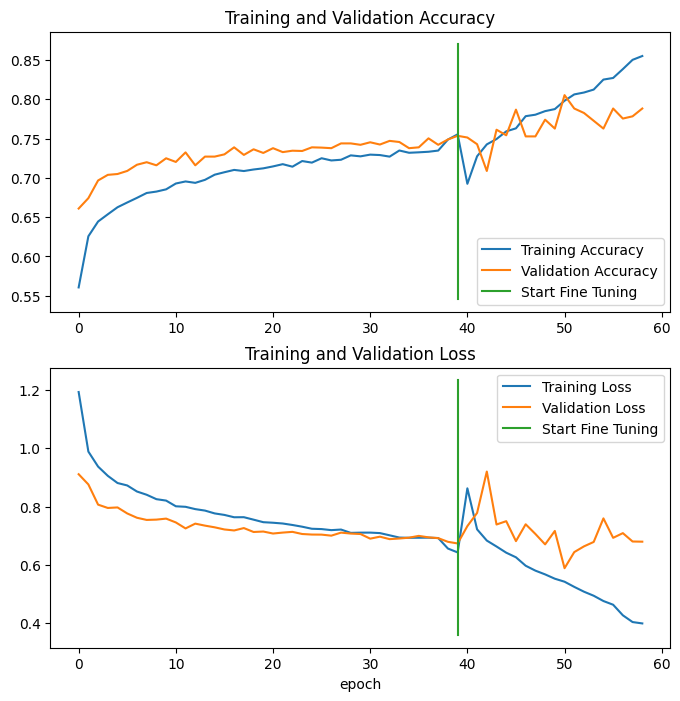

In [ ]:
compare_historys(history_11,history_f,initial_epochs = 40)

In [ ]:
pred_probs = m_11.predict(test_data_f)
pred_classes = pred_probs.argmax(axis =1)
y_labels = []
for image,label in test_data_f.unbatch():
    y_labels.append(label.numpy().argmax())

88/88 [==============================] - 8s 49ms/step


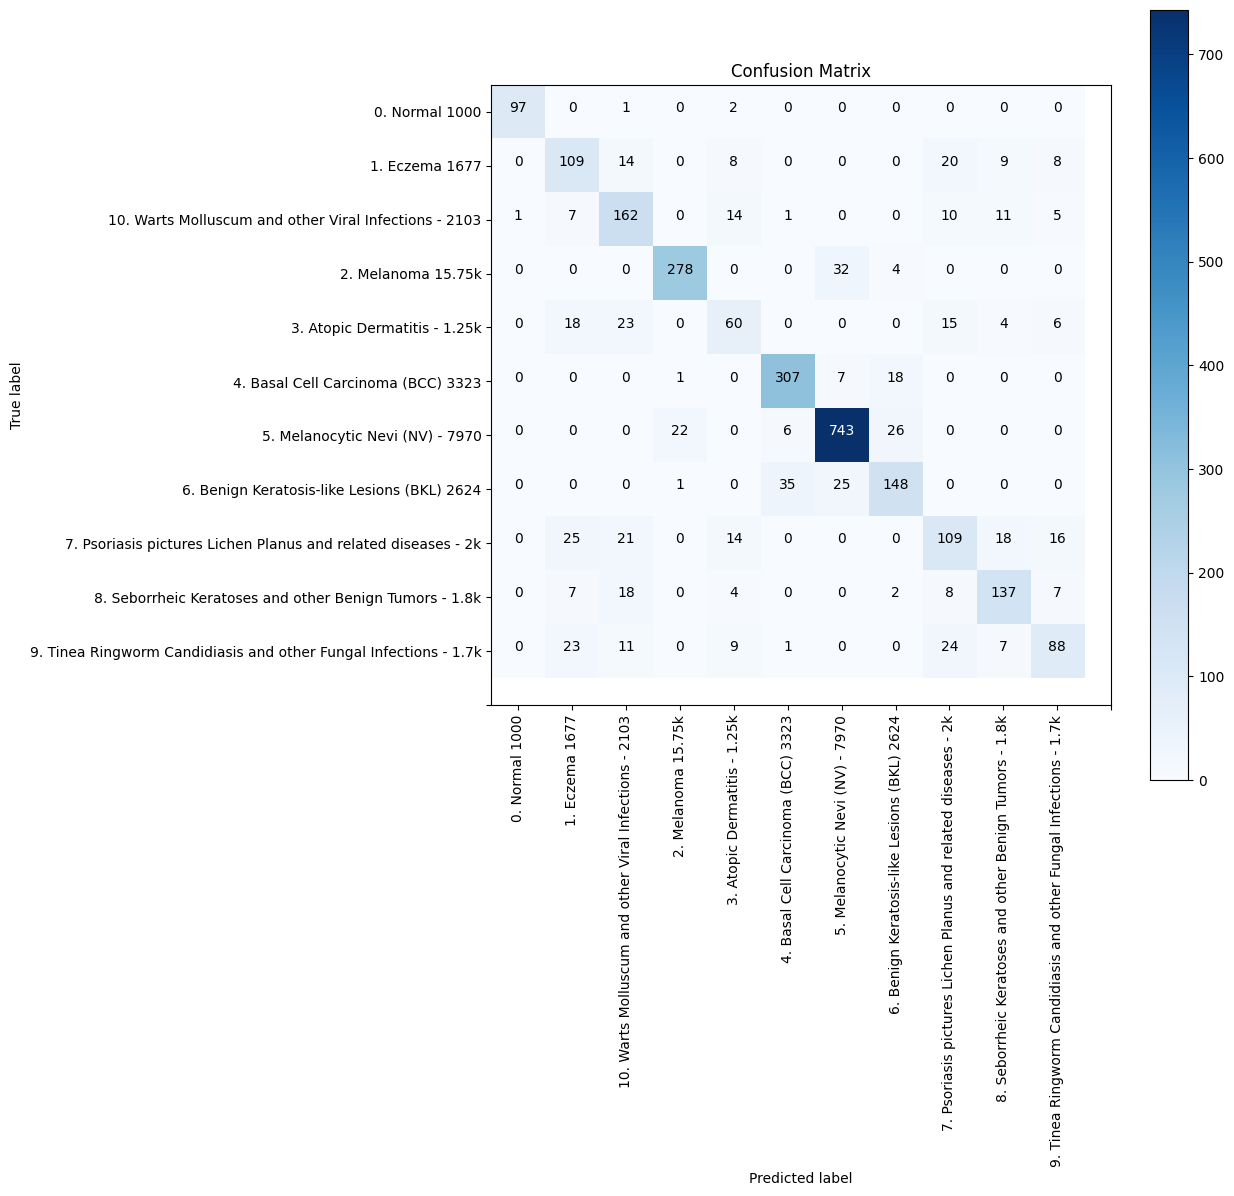

In [ ]:
# confusion matrix

make_confusion_matrix(y_labels,pred_classes,classes = class_names_2,figsize = (10,10))

In [ ]:
# classification report

print("Classification report\n",classification_report(y_labels,pred_classes))

Classification report
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.58      0.65      0.61       168
           2       0.65      0.77      0.70       211
           3       0.92      0.89      0.90       314
           4       0.54      0.48      0.51       126
           5       0.88      0.92      0.90       333
           6       0.92      0.93      0.93       797
           7       0.75      0.71      0.73       209
           8       0.59      0.54      0.56       203
           9       0.74      0.75      0.74       183
          10       0.68      0.54      0.60       163

    accuracy                           0.80      2807
   macro avg       0.75      0.74      0.74      2807
weighted avg       0.80      0.80      0.80      2807

